<a href="https://colab.research.google.com/github/adnxn93/diwali-sales-analysis/blob/main/text_mining1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import pandas as pd
import numpy as np
import re
import pickle
from collections import Counter

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For naive bayes
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# Reading the dataset with no columns titles and with latin encoding
df_raw = pd.read_csv('/content/sentiment_m140_.csv', encoding = "ISO-8859-1", header=None)

 # As the data has no column titles, we will add our own
df_raw.columns = ["sentiment", "time", "date", "query", "username", "tweet"]

# Show the first 10 rows of the dataframe.
df_raw.head()

,sentiment,time,date,query,username,tweet
0,ï»¿target,ids,date,flag,user,text
1,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
2,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
3,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
4,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire


In [ ]:
df = df_raw[['sentiment', 'tweet']]

# Replacing the label 4 with 1.
df['sentiment'] = df['sentiment'].replace(4,1)

df.head(10)

<ipython-input-29-f9f4c7c00c86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].replace(4,1)


,sentiment,tweet
0,ï»¿target,text
1,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
2,0,is upset that he can't update his Facebook by ...
3,0,@Kenichan I dived many times for the ball. Man...
4,0,my whole body feels itchy and like its on fire
5,0,"@nationwideclass no, it's not behaving at all...."
6,0,@Kwesidei not the whole crew
7,0,Need a hug
8,0,@LOLTrish hey long time no see! Yes.. Rains a...
9,0,@Tatiana_K nope they didn't have it


No trimming done


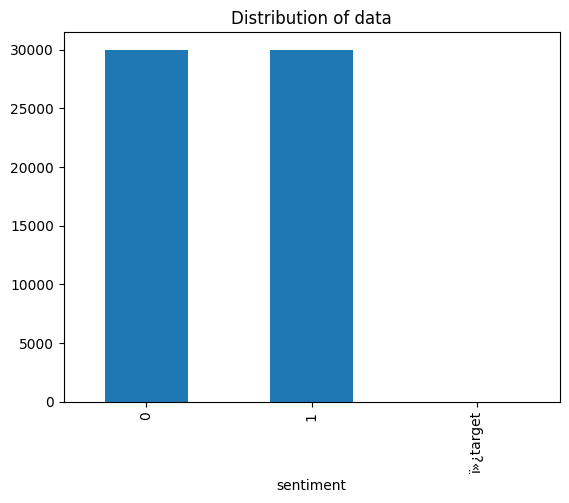

In [ ]:
trim_df = False # If you set this to true -> trim dataframe to 1/80 for efficiency

is_trimmed = False # This should always be initialized to false. Will be set to true if trimming occurs

if trim_df:
    print("Trimming the dataset to 1/80")
    print("Nr rows before trim:", len(df))
    df_pos = df[df['sentiment'] == 1]
    df_neg = df[df['sentiment'] == 0]
    df_pos = df_pos.iloc[:int(len(df_pos)/80)]
    df_neg = df_neg.iloc[:int(len(df_neg)/80)]
    df = pd.concat([df_pos, df_neg])
    trim_df = False # prevent running more than once
    is_trimmed = True
    print("Nr rows after trim:", len(df))
else:
    print("No trimming done")

    ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)


In [ ]:
df.head()

,sentiment,tweet
0,ï»¿target,text
1,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
2,0,is upset that he can't update his Facebook by ...
3,0,@Kenichan I dived many times for the ball. Man...
4,0,my whole body feels itchy and like its on fire


In [ ]:
contractions = pd.read_csv('/content/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"
def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)


    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [ ]:
df['processed_tweet'] = df.tweet.apply(preprocess_apply)

<ipython-input-33-5cba80a9918e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_tweet'] = df.tweet.apply(preprocess_apply)


In [ ]:
df.head(10)

,sentiment,tweet,processed_tweet
0,ï»¿target,text,text
1,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","<user> <url> - aww, thatis a bummer. you shou..."
2,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
3,0,@Kenichan I dived many times for the ball. Man...,<user> i dived many times for the ball. manage...
4,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
5,0,"@nationwideclass no, it's not behaving at all....","<user> no, it is not behaving at all. i am mad..."
6,0,@Kwesidei not the whole crew,<user> not the whole crew
7,0,Need a hug,need a hug
8,0,@LOLTrish hey long time no see! Yes.. Rains a...,<user> hey long time no see! yes.. rains a bi...
9,0,@Tatiana_K nope they didn't have it,<user> nope they did not have it


In [ ]:
processedtext = list(df['processed_tweet'])
if is_trimmed:
    data_pos = processedtext[10000:]
    data_neg = processedtext[:10000]
else:
    data_pos = processedtext[800000:]
    data_neg = processedtext[:800000]

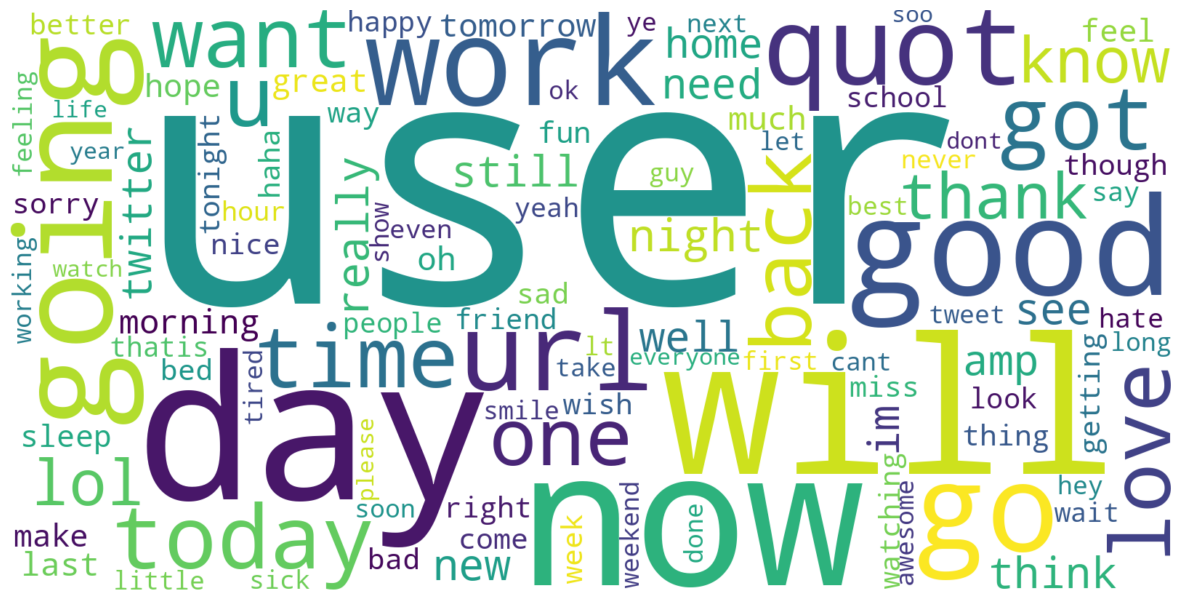

In [ ]:
plt.figure(figsize = (15,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,  background_color ='white', min_font_size = 25,
               collocations=False).generate(" ".join(data_neg))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')